# Spark practical work
### Melen Laclais, Carlos Manzano Izquierdo

## Creating spark session and load of training data

In [1]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan

# Initialize Spark Session

spark = SparkSession.builder \
    .appName("Flight_Delay_EDA_Analysis") \
    .config("spark.driver.memory", "10g") \
    .master("local[*]") \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/03 18:12:05 WARN Utils: Your hostname, MSICarlos, resolves to a loopback address: 127.0.1.1; using 158.49.196.186 instead (on interface wlo1)
26/01/03 18:12:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/03 18:12:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:

# Load Training Data (2006 + 2007)
print("Loading raw flight data (2006-2007)... This may take a moment due to schema inference...")

# We use inferSchema=True to see the actual data types Spark detects
# We use nullValue="NA" because the documentation states "NA" is used for nulls
flights_raw = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("nullValue", "NA") \
    .csv(["../training_data/flight_data/2006.csv.bz2", "../training_data/flight_data/2007.csv.bz2"])

# Load auxiliary tables for inspection
planes_df = spark.read.option("header", "true").option("inferSchema", "true").option("nullValue", "NA").csv("../training_data/flight_data/plane-data.csv")
airports_df = spark.read.option("header", "true").option("inferSchema", "true").option("nullValue", "NA").csv("../training_data/flight_data/airports.csv")

print(f"Total flights loaded: {flights_raw.count():,}")

Loading raw flight data (2006-2007)... This may take a moment due to schema inference...


Total flights loaded: 14,595,137


## Dataset exploration, analysis and processing

First, lets start by analyzing the schema of the dataset

In [3]:

print("--- Inferred Schema ---")
flights_raw.printSchema()

#(using Pandas for better formatting in Jupyter)
print("--- Data Sample (First 5 rows) ---")
flights_raw.limit(5).toPandas()

26/01/03 18:13:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


--- Inferred Schema ---
root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: i

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2006,1,11,3,743,745,1024,1018,US,343,...,45,13,0,None,0,0,0,0,0,0
1,2006,1,11,3,1053,1053,1313,1318,US,613,...,27,19,0,None,0,0,0,0,0,0
2,2006,1,11,3,1915,1915,2110,2133,US,617,...,4,11,0,None,0,0,0,0,0,0
3,2006,1,11,3,1753,1755,1925,1933,US,300,...,16,10,0,None,0,0,0,0,0,0
4,2006,1,11,3,824,832,1015,1015,US,765,...,27,12,0,None,0,0,0,0,0,0



### Data Cleaning:  Delete Forbidden variables


Now the first step that we will take is to delete all of the variables whose information would not be available during inference, the "Forbidden" variables:

* ArrTime
* ActualElapsedTime
* AirTime
* TaxiIn
* Diverted
* CarrierDelay
* WeatherDelay
* NASDelay
* SecurityDelay
* LateAircraftDelay

In [4]:

# These variables contain future information known only after landing.
forbidden_vars = [
    "ArrTime",
    "ActualElapsedTime",
    "AirTime",
    "TaxiIn",
    "Diverted",
    "CarrierDelay",
    "WeatherDelay",
    "NASDelay",
    "SecurityDelay",
    "LateAircraftDelay"
]

# Drop the forbidden columns
flights_clean = flights_raw.drop(*forbidden_vars)

print("--- Structure after removing forbidden variables ---")
flights_clean.printSchema()

print("Ensure these variables are not anymore present:\n")

error_found = False
for var in forbidden_vars:
    if var in flights_clean.columns:
        print(f"ERROR: {var} is still present!")
        error_found = True
        
if error_found:
    print("Some forbidden variables are still present. Please check the code.")
else:
    print("All forbidden variables successfully removed.")


--- Structure after removing forbidden variables ---
root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)

Ensure these variables are not anymore present:

All forbidden variables successfully removed.



### Data Cleaning: Delete canceled flights and associated columns

The first cleaning step we must do is removing all the rows whose flights were cancelled, and delete the columns which express if the flight were canceled, as they won't have useful information anymore.

In [5]:
flights_clean = flights_clean.filter("Cancelled == 0") \
                            .drop("Cancelled", "CancellationCode")
                            
flights_clean.printSchema()                            
print(f"Total valid flights for training: {flights_clean.count():,}")


root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)



Total valid flights for training: 14,312,455


### Data Cleaning: Null handling

Now we will keep assesing the quality of the features that we have available, to verify which techniques of imputation and deletion we should follow. We will also evaluate if we need to transform into categorical some of the variables,  and the consistence showed in their values. 


In [6]:
print("--- Missing Values Analysis ---")
# Calculate count of nulls for each column
null_counts = flights_clean.select([count(when(col(c).isNull(), c)).alias(c) for c in flights_clean.columns])
null_counts.show(truncate=False)

--- Missing Values Analysis ---


+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+
|0   |0    |0         |0        |0      |0         |0         |0            |0        |0      |727           |33365   |0       |0     |0   |0       |0      |
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+



The only columns that contain null values are **CRSElapsedTime** and **ArrDelay**, with **727** and **33**,**365** missing values respectively.

When dealing with the issue where a lot ot observations have a null value in ArrDelay, it maybe could be consequence of not having filtered the rows whose flight was diverted.It could make sense that  this ones does not have any value setted in the colum ArrDelay, since the flight did not arrive to his original destiny. Thus, we must check if this hypothesis is true.


In [7]:
print("---  Hypothesis Verification (ArrDelay Nulls vs Diverted) ---")

# We check the raw data to see the relationship between Null ArrDelay and Diverted status
flights_raw.filter("ArrDelay IS NULL AND Cancelled == 0") \
           .select("ArrDelay", "Diverted", "Cancelled") \
           .groupBy("Diverted") \
           .count() \
           .show()

---  Hypothesis Verification (ArrDelay Nulls vs Diverted) ---


+--------+-----+
|Diverted|count|
+--------+-----+
|       1|33365|
+--------+-----+



We can confirm our hypothesis since the number of rows which satisfy the condition is equal to the number of nulls we observed earlier in the target variable. Then, we have to process again the flights raw data in order to obtain the clean dataset without nulls in ArrDelay as consequence of flights diverted.

In [8]:
# We must filter out 'Diverted' flights BEFORE dropping the 'Diverted' column.
print("--- Applying Fix (Filtering Diverted flights ---")

# Re-creating flights_clean with the correct logic:
# Filter Cancelled AND Diverted -> Then drop forbidden variables
flights_clean = flights_raw.filter("Cancelled == 0 AND Diverted == 0") \
                           .drop(*forbidden_vars) \
                           .drop("Cancelled", "CancellationCode")
                           
print("--- Schema check after applying fix: ---")
flights_clean.printSchema()

# Checking if 'ArrDelay' still has nulls after the fix.
print("--- Final Verification (Nulls in ArrDelay) ---")

flights_clean.select(
    count(when(col("ArrDelay").isNull(), "ArrDelay")).alias("ArrDelay_Null_Count")
).show()

# Verify if the number of columns in flights_clean matches the expected count
# (Raw columns - Forbidden variables - 2 cancellation columns)
expected_count = len(flights_raw.columns) - len(forbidden_vars) - 2
actual_count = len(flights_clean.columns)

print(f"Number of columns in flights_clean: {actual_count}")
print(f"Expected number of columns: {expected_count}")

if actual_count == expected_count:
    print("Verification successful: The column count matches the expected reduction.")
else:
    print("Verification failed: The column count does not match.")



--- Applying Fix (Filtering Diverted flights ---
--- Schema check after applying fix: ---
root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)

--- Final Verification (Nulls in ArrDelay) ---


+-------------------+
|ArrDelay_Null_Count|
+-------------------+
|                  0|
+-------------------+

Number of columns in flights_clean: 17
Expected number of columns: 17
Verification successful: The column count matches the expected reduction.


Now that we have fixed the problem of the nulls in our target variable, we have to manage the **nulls of CRSElapsedTime**. So lets impute the nulls, but , how ?. We thinked about calculating the difference between the columns **CrSArrTime and CRSDepTime**, but since we are working with data from flights, this would be difficult since there are differente time zones that would complicate to calcualate this value in a straightforward way. 

Thus, we have decided to impute this values with the average of the values present in other observation for the flights with the same origin and destination.

In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, col, coalesce, round

print("--- Imputing CRSElapsedTime using Route Average ---")

# Define the Window: "Look at all flights sharing the same Origin and Dest"
route_window = Window.partitionBy("Origin", "Dest")

# Calculate the average scheduled duration for that specific route
# We use 'round' to keep it as integer minutes
avg_route_duration = round(avg("CRSElapsedTime").over(route_window))

# Apply Imputation
# If CRSElapsedTime is null, use the Route Average.
# If it's still null (e.g., a unique route with only 1 flight that is null), we drop it later.
flights_clean = flights_clean.withColumn(
    "CRSElapsedTime",
    coalesce(col("CRSElapsedTime"), avg_route_duration)
)

# Final Cleanup
# Drop any remaining nulls (routes that had NO valid data at all to learn from)
flights_clean = flights_clean.dropna(subset=["CRSElapsedTime"])

# Verification
print("--- Final Verification ---")
flights_clean.select(
    count(when(col("CRSElapsedTime").isNull(), 1)).alias("Nulls_After_Smart_Imputation")
).show()

# Show a sample of how it worked (e.g. for a specific route)
flights_clean.filter("Origin == 'JFK' AND Dest == 'LAX'") \
             .select("Origin", "Dest", "CRSDepTime", "CRSArrTime", "CRSElapsedTime") \
             .limit(5).show()

--- Imputing CRSElapsedTime using Route Average ---
--- Final Verification ---


+----------------------------+
|Nulls_After_Smart_Imputation|
+----------------------------+
|                           0|
+----------------------------+



+------+----+----------+----------+--------------+
|Origin|Dest|CRSDepTime|CRSArrTime|CRSElapsedTime|
+------+----+----------+----------+--------------+
|   JFK| LAX|      1400|      1709|         369.0|
|   JFK| LAX|      1400|      1709|         369.0|
|   JFK| LAX|      1400|      1709|         369.0|
|   JFK| LAX|      1400|      1709|         369.0|
|   JFK| LAX|      1400|      1709|         369.0|
+------+----+----------+----------+--------------+



So lets evaluate finally the null count on this dataset before making further analisys and transforamtions

In [10]:
# Calculate count of nulls for each column
null_counts = flights_clean.select([count(when(col(c).isNull(), c)).alias(c) for c in flights_clean.columns])
null_counts.show(truncate=False)

+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+
|0   |0    |0         |0        |0      |0         |0         |0            |0        |0      |0             |0       |0       |0     |0   |0       |0      |
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+



In [11]:
# Save the cleaned dataframe to a parquet file for future use
# flights_clean.write.mode("overwrite").parquet("../check_point")

# print("Dataframe successfully saved to ../check_point")

### Data Cleaning: Removal of High-Cardinality Identifiers
We proceed to remove specific identifiers that hinder model generalization and introduce noise. FlightNum is discarded as it is a non-ordinal administrative label whose predictive value is effectively redundant, being already better captured by the combination of route, carrier, and schedule information. Similarly we will remove the raw TailNum to prevent the model from overfitting to specific aircraft histories and to avoid the computational overhead associated with processing thousands of unique categorical levels(But this will be done in a few cells, since we need TailNum to join with the plane-data csv file)

In [12]:

flights_clean = flights_clean.drop("FlightNum")


### Feature Engineering: Join dataset with other files to enrich features
(*exploring additional datasets to try to find additional relevant
information*)


We have available in the dataset the csv files airports, carriers and  plane-data which we can use to enrich our dataset with more relevant features. We will explore them to asses which new variables we could obtain from joining them to our data.

In [13]:
# Explore additional datasets 
additional_datasets = {
    "planes": "../training_data/flight_data/plane-data.csv",
    "airports": "../training_data/flight_data/airports.csv",
    "carriers": "../training_data/flight_data/carriers.csv"
}
for name, path in additional_datasets.items():
    df = spark.read.option("header", "true").option("inferSchema", "true").option("nullValue", "NA").csv(path)
    print(f"--- {name.capitalize()} Dataset Schema ---")
    df.printSchema()
    print(f"--- {name.capitalize()} Dataset Sample (First 5 rows) ---")
    df.limit(5).show()

--- Planes Dataset Schema ---
root
 |-- tailnum: string (nullable = true)
 |-- type: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- issue_date: string (nullable = true)
 |-- model: string (nullable = true)
 |-- status: string (nullable = true)
 |-- aircraft_type: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- year: string (nullable = true)

--- Planes Dataset Sample (First 5 rows) ---
+-------+----+------------+----------+-----+------+-------------+-----------+----+
|tailnum|type|manufacturer|issue_date|model|status|aircraft_type|engine_type|year|
+-------+----+------------+----------+-----+------+-------------+-----------+----+
| N050AA|NULL|        NULL|      NULL| NULL|  NULL|         NULL|       NULL|NULL|
| N051AA|NULL|        NULL|      NULL| NULL|  NULL|         NULL|       NULL|NULL|
| N052AA|NULL|        NULL|      NULL| NULL|  NULL|         NULL|       NULL|NULL|
| N054AA|NULL|        NULL|      NULL| NULL|  NULL|         N

We will only use plane-data and airports csv's, since the information available in carriers does not give us useful information for our prediction. We can appreciate that apparantly, plane-data csv have some empty observations. Lets verify that.

In [14]:
#Verify null observations and columns in additional datasets
for name, path in additional_datasets.items():
    df = spark.read.option("header", "true").option("inferSchema", "true").option("nullValue", "NA").csv(path)
    print(f"--- {name.capitalize()} Dataset Null Values Analysis ---")
    null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
    null_counts.show(truncate=False)

--- Planes Dataset Null Values Analysis ---
+-------+----+------------+----------+-----+------+-------------+-----------+----+
|tailnum|type|manufacturer|issue_date|model|status|aircraft_type|engine_type|year|
+-------+----+------------+----------+-----+------+-------------+-----------+----+
|0      |549 |549         |549       |549  |549   |549          |549        |549 |
+-------+----+------------+----------+-----+------+-------------+-----------+----+

--- Airports Dataset Null Values Analysis ---
+----+-------+----+-----+-------+---+----+
|iata|airport|city|state|country|lat|long|
+----+-------+----+-----+-------+---+----+
|0   |0      |12  |12   |0      |0  |0   |
+----+-------+----+-----+-------+---+----+

--- Carriers Dataset Null Values Analysis ---
+----+-----------+
|Code|Description|
+----+-----------+
|1   |0          |
+----+-----------+



Now that we have seen that there are some nulls present in the auxiliar tables, we will have to manage that before joining the tables. 

Thus, We will  first perform a quality check on the auxiliary tables, removing records with missing critical information—such as aircraft manufacturing year or airport geographical coordinates—to prevent propagating noise.

We will then execute a series of left joins to incorporate the aircraft's manufacturing year and the geographical context (state and coordinates) for both the origin and destination airports. Finally, we implement a post-join validation step by removing flight records that failed to match with these auxiliary tables. This ensures data integrity and a consistent feature set for the subsequent creation of engineered variables.

In [18]:
from pyspark.sql.functions import col, broadcast

# load dataframes 
planes_df = spark.read.option("header", "true").option("inferSchema", "true").option("nullValue", "NA").csv("../training_data/flight_data/plane-data.csv")
airports_df = spark.read.option("header", "true").option("inferSchema", "true").option("nullValue", "NA").csv("../training_data/flight_data/airports.csv")



# 1. Pre-cleaning 
# ----------------------------------------------------------
planes_clean = planes_df.dropna(subset=["year", "manufacturer"]) \
                        .select(col("tailnum").alias("TailNum_Ref"), 
                                col("year").alias("PlaneYear"),
                                col("manufacturer").alias("PlaneManufacturer"))

airports_clean = airports_df.dropna(subset=["city", "state"]) \
                            .select(col("iata").alias("iata_ref"), 
                                    col("city"), col("state"), 
                                    col("lat"), col("long"))

# 2. Executing Joins
# ----------------------------------------------------------


# Plane data
enriched_df = flights_clean.join(broadcast(planes_clean), 
                                 flights_clean.TailNum == planes_clean.TailNum_Ref, "left")

# Origin Airport data
enriched_df = enriched_df.join(
    broadcast(airports_clean.select(col("iata_ref").alias("O_ref"), 
                                    col("city").alias("Origin_City"),
                                    col("state").alias("Origin_State"), 
                                    col("lat").alias("Origin_Lat"), 
                                    col("long").alias("Origin_Long"))),
    col("Origin") == col("O_ref"), "left"
)

# Destination Airport data
enriched_df = enriched_df.join(
    broadcast(airports_clean.select(col("iata_ref").alias("D_ref"), 
                                    col("city").alias("Dest_City"),
                                    col("state").alias("Dest_State"), 
                                    col("lat").alias("Dest_Lat"), 
                                    col("long").alias("Dest_Long"))),
    col("Dest") == col("D_ref"), "left"
)

# 3. Data Loss Verification (The Diagnostic)
# ----------------------------------------------------------
print("--- Data Coverage Analysis (Missing Matches) ---")

total_flights = enriched_df.count()

# Count nulls for each source
stats = enriched_df.select(
    count(when(col("PlaneYear").isNull(), 1)).alias("Missing_Plane_Info"),
    count(when(col("Origin_City").isNull(), 1)).alias("Missing_Origin_Info"),
    count(when(col("Dest_City").isNull(), 1)).alias("Missing_Dest_Info")
).collect()[0]

print(f"Total Rows: {total_flights:,}")
print(f"Flights without Plane metadata: {stats['Missing_Plane_Info']:,} ({stats['Missing_Plane_Info']/total_flights:.2%})")
print(f"Flights without Origin metadata: {stats['Missing_Origin_Info']:,} ({stats['Missing_Origin_Info']/total_flights:.2%})")
print(f"Flights without Destination metadata: {stats['Missing_Dest_Info']:,} ({stats['Missing_Dest_Info']/total_flights:.2%})")

# 4. Final Cleanup (Turning Left Join into "Inner Join" logic)
# ----------------------------------------------------------
enriched_df = enriched_df.dropna(subset=["PlaneYear", "Origin_City", "Dest_City"])
enriched_df = enriched_df.drop("TailNum_Ref", "O_ref", "D_ref")

print(f"\nFinal training set size: {enriched_df.count():,}")

print(f"Final column count: {len(enriched_df.columns)}")
enriched_df.printSchema()

print("--- Enriched Data Sample (First 5 rows) ---")
enriched_df.limit(5).show()

# 5. Null value analysis after enrichment
print("--- Null Values Analysis after Enrichment ---")
null_counts = enriched_df.select([count(when(col(c).isNull(), c)).alias(c) for c in enriched_df.columns])
null_counts.show(truncate=False)

# Persist in cache for faster future access
enriched_df = enriched_df.cache()

--- Data Coverage Analysis (Missing Matches) ---


Total Rows: 14,279,090
Flights without Plane metadata: 2,350,705 (16.46%)
Flights without Origin metadata: 9,926 (0.07%)
Flights without Destination metadata: 9,968 (0.07%)



Final training set size: 11,910,044
Final column count: 26
root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- PlaneYear: string (nullable = true)
 |-- PlaneManufacturer: string (nullable = true)
 |-- Origin_City: string (nullable = true)
 |-- Origin_State: string (nullable = true)
 |-- Origin_Lat: double (nullable = true)
 |-- Origin_Long: double (nullable = true)
 |-- Dest_City: stri

+----+-----+----------+---------+-------+----------+----------+-------------+-------+--------------+--------+--------+------+----+--------+-------+---------+-----------------+-----------+------------+----------+-----------+---------+----------+--------+---------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|TailNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|PlaneYear|PlaneManufacturer|Origin_City|Origin_State|Origin_Lat|Origin_Long|Dest_City|Dest_State|Dest_Lat|Dest_Long|
+----+-----+----------+---------+-------+----------+----------+-------------+-------+--------------+--------+--------+------+----+--------+-------+---------+-----------------+-----------+------------+----------+-----------+---------+----------+--------+---------+
|0   |0    |0         |0        |0      |0         |0         |0            |0      |0             |0       |0       |0     |0   |0       |0      |0        |0                |0          |0           |0       

26/01/03 18:29:29 WARN CacheManager: Asked to cache already cached data.        


### Feature Engineering: Agreggation and mixing of columns in order to create new columns that could be useful 

With the external datasets successfully integrated, we now transform raw data into more meaningful predictors for the model. We calculate the aircraft's age—derived from the flight year and manufacture year—to capture potential mechanical reliability trends. To account for daily operational cycles and peak congestion, we extract the scheduled departure hour from the timestamp. Additionally, we create a binary indicator to distinguish weekend traffic dynamics from business-day patterns. To conclude this stage, we drop the raw manufacture year and aircraft identifiers, refining our feature space to focus on generalized signals rather than specific registrations.

In [19]:
from pyspark.sql.functions import col, floor, expr

enriched_df = enriched_df.withColumn(
    "PlaneAge", 
    (col("Year") - expr("try_cast(PlaneYear AS INT)")).cast("int")
)

enriched_df = enriched_df.withColumn(
    "DepHour", 
    floor(expr("try_cast(CRSDepTime AS INT)") / 100).cast("int")
)

enriched_df = enriched_df.withColumn(
    "IsWeekend",
    (expr("try_cast(DayOfWeek AS INT)") > 5).cast("int")
)

#  Final Cleanup
enriched_df = enriched_df.drop("TailNum", "PlaneYear")

print("--- New Features Created with Spark 4.0 Safety ---")
enriched_df.printSchema()
enriched_df.select("Year", "PlaneAge", "DepHour", "IsWeekend").show(5)

--- New Features Created with Spark 4.0 Safety ---
root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- PlaneManufacturer: string (nullable = true)
 |-- Origin_City: string (nullable = true)
 |-- Origin_State: string (nullable = true)
 |-- Origin_Lat: double (nullable = true)
 |-- Origin_Long: double (nullable = true)
 |-- Dest_City: string (nullable = true)
 |-- Dest_State: string (nullable = true)
 |-- Dest_Lat: double (nul

In [20]:
# ==========================================================
# Column Reordering
# ==========================================================

# Grouping columns by logic: Temporal, Operational, Geographic, and Metrics
ordered_columns = [
    # 1. Temporal Features
    "Year", "Month", "DayofMonth", "DayOfWeek", "IsWeekend", "DepHour",
    
    # 2. Flight & Aircraft Information
    "UniqueCarrier", "Distance", "PlaneManufacturer", "PlaneAge",
    
    # 3. Schedule Information
    "CRSDepTime", "CRSArrTime", "CRSElapsedTime",
    
    # 4. Origin Geography
    "Origin", "Origin_City", "Origin_State", "Origin_Lat", "Origin_Long",
    
    # 5. Destination Geography
    "Dest", "Dest_City", "Dest_State", "Dest_Lat", "Dest_Long",
    
    # 6. Real-time Metrics and Target Variable
    "DepTime", "DepDelay", "TaxiOut", "ArrDelay"
]

# Apply the selection
enriched_df = enriched_df.select(*ordered_columns)

print("--- Dataframe successfully reordered ---")
enriched_df.limit(5).show()

--- Dataframe successfully reordered ---
+----+-----+----------+---------+---------+-------+-------------+--------+-----------------+--------+----------+----------+--------------+------+-----------+------------+-----------+------------+----+-----------+----------+-----------+------------+-------+--------+-------+--------+
|Year|Month|DayofMonth|DayOfWeek|IsWeekend|DepHour|UniqueCarrier|Distance|PlaneManufacturer|PlaneAge|CRSDepTime|CRSArrTime|CRSElapsedTime|Origin|Origin_City|Origin_State| Origin_Lat| Origin_Long|Dest|  Dest_City|Dest_State|   Dest_Lat|   Dest_Long|DepTime|DepDelay|TaxiOut|ArrDelay|
+----+-----+----------+---------+---------+-------+-------------+--------+-----------------+--------+----------+----------+--------------+------+-----------+------------+-----------+------------+----+-----------+----------+-----------+------------+-------+--------+-------+--------+
|2007|    4|         8|        7|        1|     14|           AS|     914|           BOEING|      15|      143

### Checkpoint to save work done in the session

In [ ]:
# enriched_df.write.mode("overwrite").parquet("../check_point_v1")

### Load saved data 


In [ ]:
# enriched_df = spark.read.parquet("../check_point_v1", header=True, inferSchema=False)

# enriched_df.printSchema()
# enriched_df.limit(5).show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- IsWeekend: integer (nullable = true)
 |-- DepHour: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- PlaneManufacturer: string (nullable = true)
 |-- PlaneAge: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Origin_City: string (nullable = true)
 |-- Origin_State: string (nullable = true)
 |-- Origin_Lat: double (nullable = true)
 |-- Origin_Long: double (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Dest_City: string (nullable = true)
 |-- Dest_State: string (nullable = true)
 |-- Dest_Lat: double (nullable = true)
 |-- Dest_Long: double (nullable = true)
 |-- DepTime: integer (nullable = t

### Feature Engineering: Last steps in cleaning an refining data 

In [21]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, expr, lower, trim, count, when

# 1. Data Ingestion
# enriched_df = spark.read.parquet("../check_point_v1")

# 2. Raw Normalization Layer
# Cast all columns to StringType initially to create a uniform processing buffer.
# This prevents implicit casting issues by treating all input data as raw text 
# before enforcing the target schema.
temp_df = enriched_df.select([
    col(c).cast(StringType()).alias(c) for c in enriched_df.columns
])

# 3. Schema Enforcement and Sanitization
# Apply transformation logic based on the original schema definition.
# We iterate through the expected fields to restore the correct data types safely.
cleaned_df = temp_df
for field in enriched_df.schema.fields:
    col_name = field.name
    dtype = field.dataType.simpleString()
    
    if dtype == 'string':
        # Text fields: Trim whitespace and normalize specific placeholders to NULL
        cleaned_df = cleaned_df.withColumn(
            col_name,
            expr(f"nullif(trim({col_name}), 'None')")
        )
    else:
        # Numeric/Other fields: Sanitize string input and apply safe casting.
        # 'try_cast' guarantees that malformed strings become NULLs instead of exceptions.
        safe_expr = f"try_cast(nullif(trim({col_name}), 'None') as {dtype})"
        cleaned_df = cleaned_df.withColumn(col_name, expr(safe_expr))

# 4. Deduplication
# Removing duplicates on the sanitized dataset ensures data integrity.
enriched_df = cleaned_df.dropDuplicates()

# 5. Feature Refinement and Logical Filtering
# Normalize categorical entities and apply domain-specific constraints (e.g., non-negative PlaneAge).
enriched_df = enriched_df.withColumn(
    "PlaneManufacturer", lower(trim(col("PlaneManufacturer")))
).filter(
    (col("ArrDelay").isNotNull()) & 
    (expr("try_cast(PlaneAge as int) IS NULL OR try_cast(PlaneAge as int) >= 0"))
)

# 6. Quality Assurance Metrics
print(f"Total records after cleaning: {enriched_df.count()}")
print("--- Null Summary ---")
enriched_df.select([count(when(col(c).isNull(), c)).alias(c) for c in enriched_df.columns]).show()

Total records after cleaning: 11908197
--- Null Summary ---


+----+-----+----------+---------+---------+-------+-------------+--------+-----------------+--------+----------+----------+--------------+------+-----------+------------+----------+-----------+----+---------+----------+--------+---------+-------+--------+-------+--------+
|Year|Month|DayofMonth|DayOfWeek|IsWeekend|DepHour|UniqueCarrier|Distance|PlaneManufacturer|PlaneAge|CRSDepTime|CRSArrTime|CRSElapsedTime|Origin|Origin_City|Origin_State|Origin_Lat|Origin_Long|Dest|Dest_City|Dest_State|Dest_Lat|Dest_Long|DepTime|DepDelay|TaxiOut|ArrDelay|
+----+-----+----------+---------+---------+-------+-------------+--------+-----------------+--------+----------+----------+--------------+------+-----------+------------+----------+-----------+----+---------+----------+--------+---------+-------+--------+-------+--------+
|   0|    0|         0|        0|        0|      0|            0|       0|                0|  349524|         0|         0|             0|     0|          0|           0|         0|

In [22]:
from pyspark.ml.feature import Imputer

# STRATEGY: Median Imputation
# We choose median over mean because PlaneAge distribution is likely right-skewed 
# (many new planes, few very old ones). Median is robust to outliers.

# 1. Calculate the median age ignoring nulls
# approxQuantile is efficient for large datasets in Spark
median_age = enriched_df.stat.approxQuantile("PlaneAge", [0.5], 0.001)[0]

print(f"Median Plane Age calculated: {median_age}")

# 2. Fill NULL values with the calculated median
# This preserves the 350k records for model training
enriched_df = enriched_df.fillna(median_age, subset=["PlaneAge"])

# 3. Verification
enriched_df.select([count(when(col("PlaneAge").isNull(), "PlaneAge")).alias("PlaneAge_Nulls")]).show()



Median Plane Age calculated: 7.0


+--------------+
|PlaneAge_Nulls|
+--------------+
|             0|
+--------------+



### EDA and Statistical Analysys 
*(Proper exploratory data analysis (possibly including univariate and/or multivariate
analysis) to better understand the input data and provide robust criteria for variable
selection.)*

--- Univariate Statistical Moments ---
           Feature        Mean      StdDev   Skewness     Kurtosis
0         Distance  721.110885  568.805225   1.699308     3.598435
1         PlaneAge   11.265742   58.915186  33.334541  1125.921182
2   CRSElapsedTime  127.155346   70.485847   1.655152     3.679105
3         DepDelay   10.793109   34.880323   5.883906    88.095569
4          TaxiOut   16.656447   11.614469   4.726435    46.119818
5         ArrDelay    9.732849   38.130588   5.027842    62.095058
6       Origin_Lat   36.922245    5.654663  -0.115851     1.664560
7      Origin_Long  -95.380346   18.227512  -0.983295     0.862941
8         Dest_Lat   36.922674    5.656633  -0.117027     1.665263
9        Dest_Long  -95.381684   18.233133  -0.982632     0.860400
10         DepHour   13.027013    4.635881   0.089299    -1.025094


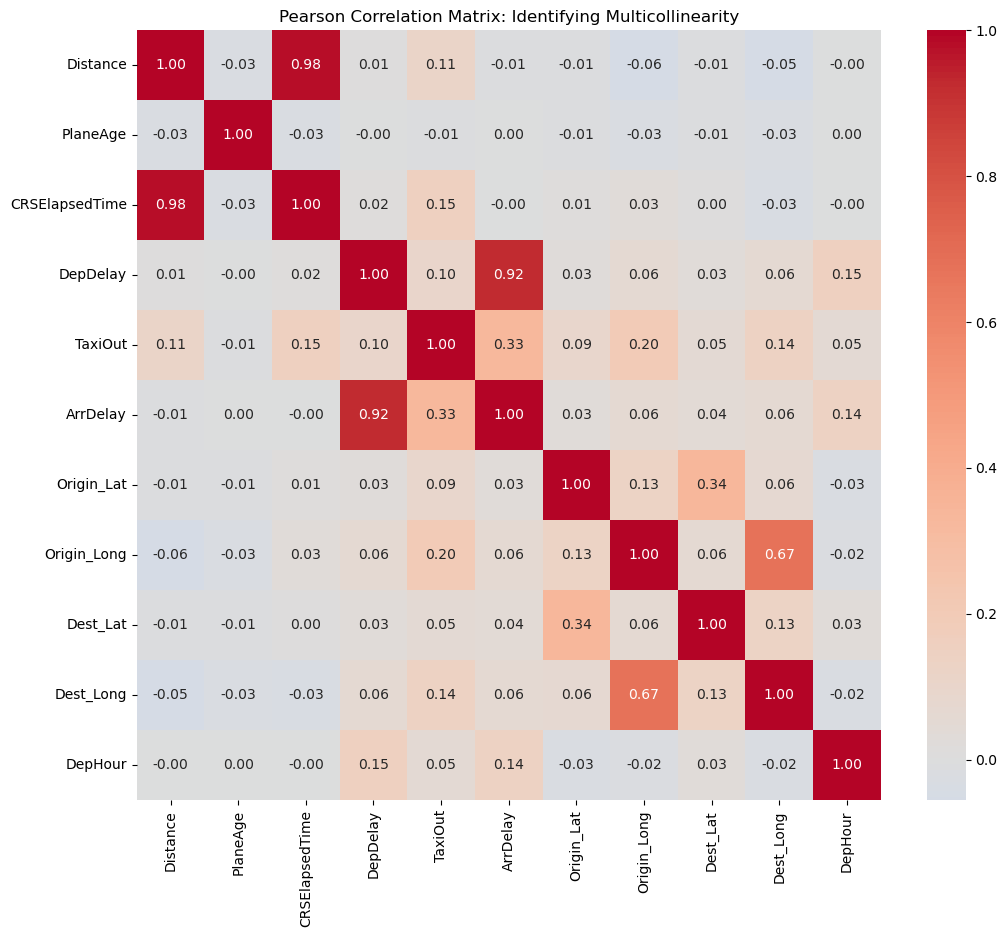


Mahalanobis Threshold (99.9% confidence): 31.2641
--- Outlier Detection Summary ---
   is_multivariate_outlier     count
0                     True    436115
1                    False  11472082


Final dataset size after cleaning: 11472082


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType
from scipy.stats import chi2

# ---  Define numerical features for multivariate analysis ---
# We include spatial, temporal, and operational metrics relevant to flight delays
numerical_cols = [
    "Distance", "PlaneAge", "CRSElapsedTime", "DepDelay", "TaxiOut", 
    "ArrDelay", "Origin_Lat", "Origin_Long", "Dest_Lat", "Dest_Long", "DepHour"
]

# ---  Compute Statistical Moments (Univariate Analysis) ---
# We calculate Mean, StdDev, Skewness, and Kurtosis to understand data distribution
agg_exprs = []
for c in numerical_cols:
    agg_exprs.extend([
        F.mean(c).alias(f"{c}_mean"),
        F.stddev(c).alias(f"{c}_std"),
        F.skewness(c).alias(f"{c}_skew"),
        F.kurtosis(c).alias(f"{c}_kurt")
    ])

# Execute aggregation and collect results
stats_row = enriched_df.select(agg_exprs).collect()[0]

stats_list = []
for c in numerical_cols:
    stats_list.append({
        "Feature": c,
        "Mean": stats_row[f"{c}_mean"],
        "StdDev": stats_row[f"{c}_std"],
        "Skewness": stats_row[f"{c}_skew"],
        "Kurtosis": stats_row[f"{c}_kurt"]
    })

stats_summary_df = pd.DataFrame(stats_list)
print("--- Univariate Statistical Moments ---")
print(stats_summary_df)

# ---  Correlation Matrix and Visual Heatmap ---
# VectorAssembler is required for Spark MLlib correlation functions
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="stat_features", handleInvalid="skip")
vector_df = assembler.transform(enriched_df).select("stat_features")

# Compute Pearson Correlation Matrix (distributed)
matrix_obj = Correlation.corr(vector_df, "stat_features").head()[0]
corr_matrix_np = matrix_obj.toArray()

# Plotting Heatmap for Collinearity Detection
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(corr_matrix_np, index=numerical_cols, columns=numerical_cols), 
            annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Pearson Correlation Matrix: Identifying Multicollinearity")
plt.show()

# ---  Active Multivariate Outlier Detection (Mahalanobis D^2) ---
# Reconstruction of Covariance Matrix: S = D * R * D (where D is diagonal of StdDev)
std_devs = stats_summary_df["StdDev"].values
means = stats_summary_df["Mean"].values
cov_matrix = np.diag(std_devs) @ corr_matrix_np @ np.diag(std_devs)

try:
    # Compute Inverse Covariance Matrix
    inv_cov = np.linalg.inv(cov_matrix)
    
    # Define Chi-Square Threshold (Alpha = 0.001) for p variables
    df_degrees = len(numerical_cols)
    mahalanobis_threshold = chi2.ppf(0.999, df_degrees)
    
    # Define a UDF to calculate the squared distance for each row
    def calculate_d2(vec):
        if vec is None: return None
        diff = vec.toArray() - means
        d2 = diff.T @ inv_cov @ diff
        return float(d2)

    mahalanobis_udf = F.udf(calculate_d2, DoubleType())

    # Apply UDF and Tag Outliers in the Spark DataFrame
    enriched_df = assembler.transform(enriched_df) \
        .withColumn("mahalanobis_d2", mahalanobis_udf(F.col("stat_features"))) \
        .withColumn("is_multivariate_outlier", F.col("mahalanobis_d2") > mahalanobis_threshold)

    # Statistical summary of detected outliers
    outlier_stats = enriched_df.groupBy("is_multivariate_outlier").count().toPandas()
    print(f"\nMahalanobis Threshold (99.9% confidence): {mahalanobis_threshold:.4f}")
    print("--- Outlier Detection Summary ---")
    print(outlier_stats)

    # ---  Data Filtering ---
    # We remove multivariate outliers to ensure model robustness
    enriched_df_clean = enriched_df.filter(F.col("is_multivariate_outlier") == False) \
                                   .drop("stat_features", "mahalanobis_d2", "is_multivariate_outlier")
    
    print(f"Final dataset size after cleaning: {enriched_df_clean.count()}")

except np.linalg.LinAlgError:
    print("CRITICAL ERROR: Covariance matrix is singular. Perfect multicollinearity detected.")

After looking at the results, we can see how the feature **PlaneAge** presents too big values for kourtosis and skewness moments. Thus, we can assume that there are big outliers in the column of the dataset, which we will have to explore if have been deleted when filtering with the mahalanobis distance. Lets explore again the distribution of this data after filtering the dataset

--- PlaneAge Distribution Summary (Post-Mahalanobis) ---


Minimum Age: 0
1st Percentile: 0
25th Percentile (Q1): 4
50th Percentile (Median): 7
75th Percentile (Q3): 14
95th Percentile: 21
99th Percentile: 38
Maximum Age: 51


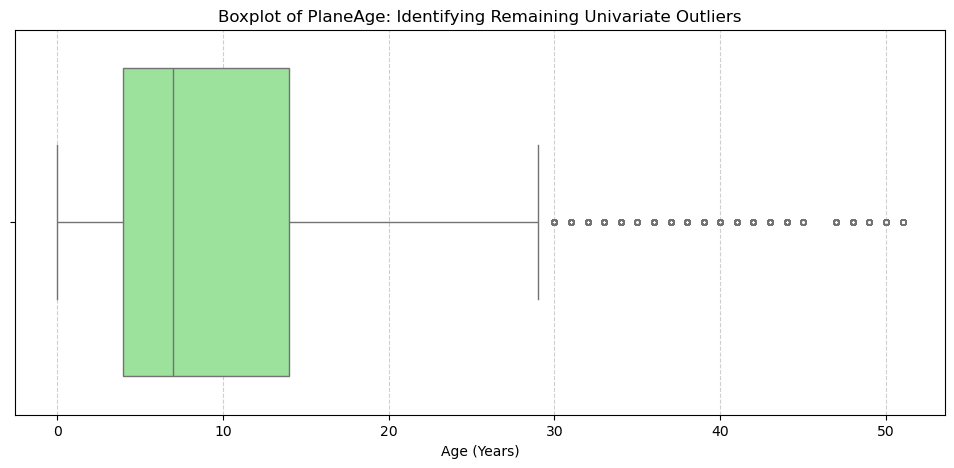


--- Most Frequent PlaneAge Values (Data Quality Check) ---


+--------+-------+
|PlaneAge|  count|
+--------+-------+
|       7|1182129|
|       5| 941287|
|       6| 933416|
|       4| 835056|
|       3| 788567|
|       8| 747814|
|       2| 624050|
|       9| 508767|
|       1| 479964|
|      19| 360728|
+--------+-------+
only showing top 10 rows


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

enriched_df_clean.cache()
enriched_df.unpersist()


# ---  Detailed Statistical Summary of PlaneAge ---
# We use percentiles to understand the distribution's spread after multivariate cleaning.
# This helps identify if univariate 'nonsense' values still persist.
print("--- PlaneAge Distribution Summary (Post-Mahalanobis) ---")
age_stats = enriched_df_clean.select(
    F.min("PlaneAge").alias("min"),
    F.percentile_approx("PlaneAge", 0.01).alias("p1"),
    F.percentile_approx("PlaneAge", 0.25).alias("p25"),
    F.percentile_approx("PlaneAge", 0.50).alias("median"),
    F.percentile_approx("PlaneAge", 0.75).alias("p75"),
    F.percentile_approx("PlaneAge", 0.95).alias("p95"),
    F.percentile_approx("PlaneAge", 0.99).alias("p99"),
    F.max("PlaneAge").alias("max")
).collect()[0]

# Displaying stats in a clean format
print(f"Minimum Age: {age_stats['min']}")
print(f"1st Percentile: {age_stats['p1']}")
print(f"25th Percentile (Q1): {age_stats['p25']}")
print(f"50th Percentile (Median): {age_stats['median']}")
print(f"75th Percentile (Q3): {age_stats['p75']}")
print(f"95th Percentile: {age_stats['p95']}")
print(f"99th Percentile: {age_stats['p99']}")
print(f"Maximum Age: {age_stats['max']}")

# ---  Visualization with Boxplot ---
# We take a 5% sample to visualize the distribution without overloading the driver's memory.
# The boxplot will clearly show if there are still extreme outliers impacting the model.
age_sample_pd = enriched_df_clean.select("PlaneAge").sample(False, 0.05, seed=42).toPandas()

plt.figure(figsize=(12, 5))
sns.boxplot(x=age_sample_pd["PlaneAge"], color='lightgreen', fliersize=4)
plt.title("Boxplot of PlaneAge: Identifying Remaining Univariate Outliers")
plt.xlabel("Age (Years)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# ---  Frequency Analysis of Extreme or Suspicious Values ---
# If the Kurtosis remains high, it's often due to "dummy" values (like 0 or 999).
# We check the top 10 most frequent values to ensure no data-entry artifacts remain.
print("\n--- Most Frequent PlaneAge Values (Data Quality Check) ---")
enriched_df_clean.groupBy("PlaneAge").count().orderBy(F.desc("count")).show(10)

After looking at these results, we can verify that now, the column PlaneAge have been pretty rewarded by the application of the filtering using mahalanobis distance, since its most extreme values has disapeared. Thus, the only transformation left to do is to delete CRSElapsed time, since it is highly correlated with the distance (since it is a function of the distance) and it could raise the coefficients of the models that will be applied.

In [26]:
from pyspark.sql import functions as F

# ---  Feature Pruning ---
# We remove 'CRSElapsedTime' to prevent multicollinearity with 'Distance'.
# This ensures that our regression coefficients reflect the independent impact of each feature.
enriched_df_clean = enriched_df_clean.drop("CRSElapsedTime")

# ---  Final Data Consistency Check ---
# We ensure the target variable 'ArrDelay' is properly cast to Double for MLlib compatibility.
# We also apply a global filter for any unexpected NULLs that might have survived 
# the previous transformations.
enriched_df_clean = enriched_df_clean.withColumn("ArrDelay", F.col("ArrDelay").cast("double")) \
                                     .dropna(subset=["ArrDelay"])


# ---  Verification of Data Integrity ---
final_count = enriched_df_clean.count()
print(f"--- Dataset Ready for Modeling ---")
print(f"Final observation count: {final_count:,}")
print(f"Number of available predictors: {len(enriched_df_clean.columns) - 1}")

# Displaying the final schema to ensure it matches the MLlib requirements
enriched_df_clean.printSchema()

--- Dataset Ready for Modeling ---
Final observation count: 11,472,082
Number of available predictors: 25
root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- IsWeekend: integer (nullable = true)
 |-- DepHour: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- PlaneManufacturer: string (nullable = true)
 |-- PlaneAge: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Origin_City: string (nullable = true)
 |-- Origin_State: string (nullable = true)
 |-- Origin_Lat: double (nullable = true)
 |-- Origin_Long: double (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Dest_City: string (nullable = true)
 |-- Dest_State: string (nullable = true)
 |-- Dest_Lat: double (nullable = true)
 |-- Dest_Long: 

We have forgotten to delete temporary columns used during the EDA. We have to delete them before the modeling phase 

In [27]:
# Clean up temporary columns
# We drop 'features_vector' and 'is_outlier' as they are no longer needed
df = enriched_df_clean.drop("features_vector", "is_outlier")

Now that we have finished with the numerical features, we have to analyze which of the categorical features we shoul retain or delete.

In [28]:
from pyspark.sql import functions as F

# 1. Clean up requested artifacts
# Dropping temporary columns from outlier detection to free up memory
df_cleaned = df.drop("is_outlier", "features_vector")

# 2. Identify all potential categorical columns (Strings and Discrete Integers)
# We include temporal variables as they are logically categorical
all_categorical = [
    "Year", "Month", "DayofMonth", "DayOfWeek", "IsWeekend", "DepHour",
    "UniqueCarrier", "Origin", "Origin_City", "Origin_State", 
    "Dest", "Dest_City", "Dest_State", "PlaneManufacturer"
]

print(f"{'Column Name':<20} | {'Distinct Values':<15} | {'Null Count':<10}")
print("-" * 55)

# 3. Distributed Analysis of Cardinality
# We use a single pass where possible to avoid multiple scans of 11M rows
analysis_results = []
for col_name in all_categorical:
    stats = df_cleaned.select(
        F.approx_count_distinct(col_name).alias("cardinality"),
        F.count(F.when(F.col(col_name).isNull(), col_name)).alias("nulls")
    ).collect()[0]
    
    cardinality = stats["cardinality"]
    nulls = stats["nulls"]
    analysis_results.append((col_name, cardinality, nulls))
    
    print(f"{col_name:<20} | {cardinality:<15} | {nulls:<10}")

# 4. Logic for Feature Selection Strategy
# High cardinality columns like 'Origin_City' might be redundant if 'Origin' is present.
# 'Year' might be useless if it's a constant value (0 variance).

Column Name          | Distinct Values | Null Count
-------------------------------------------------------


Year                 | 2               | 0         


Month                | 12              | 0         


DayofMonth           | 32              | 0         


DayOfWeek            | 7               | 0         


IsWeekend            | 2               | 0         


DepHour              | 25              | 0         


UniqueCarrier        | 17              | 0         


Origin               | 281             | 0         


Origin_City          | 279             | 0         


Origin_State         | 55              | 0         


Dest                 | 281             | 0         


Dest_City            | 277             | 0         


Dest_State           | 55              | 0         


PlaneManufacturer    | 36              | 0         


In [29]:
from pyspark.sql import functions as F

print(f"{'Variable':<20} | {'Cardinality':<12} | {'StdDev of Means':<18} | {'Range (Max-Min)':<15}")
print("-" * 80)

# We use a loop to process each, but within a single Spark execution context
for col_name in all_categorical:
    # Aggregating to find the mean ArrDelay for each level of the category
    stats_df = df_cleaned.groupBy(col_name).agg(
        F.avg("ArrDelay").alias("mean_delay"),
        F.count("*").alias("count")
    ).filter("count > 50") # Removing noise from rare levels

    # Calculating how much the means vary between categories
    # Higher StdDev means the variable is a better discriminator
    summary = stats_df.select(
        F.stddev("mean_delay").alias("std_means"),
        (F.max("mean_delay") - F.min("mean_delay")).alias("range_means")
    ).collect()[0]

    cardinality = df_cleaned.select(F.approx_count_distinct(col_name)).collect()[0][0]
    
    std_val = summary['std_means'] if summary['std_means'] else 0
    range_val = summary['range_means'] if summary['range_means'] else 0
    
    print(f"{col_name:<20} | {cardinality:<12} | {std_val:<18.4f} | {range_val:<15.2f}")

Variable             | Cardinality  | StdDev of Means    | Range (Max-Min)
--------------------------------------------------------------------------------


Year                 | 2            | 0.3936             | 0.56           


Month                | 12           | 2.1445             | 6.54           


DayofMonth           | 32           | 1.3282             | 5.33           


DayOfWeek            | 7            | 2.0989             | 6.18           


IsWeekend            | 2            | 1.6438             | 2.32           


DepHour              | 25           | 6.0675             | 18.11          


UniqueCarrier        | 17           | 3.6252             | 15.94          


Origin               | 281          | 4.2096             | 28.53          


Origin_City          | 279          | 4.2476             | 28.53          


Origin_State         | 55           | 2.6983             | 13.49          


Dest                 | 281          | 4.2311             | 23.67          


Dest_City            | 277          | 4.2482             | 23.67          


Dest_State           | 55           | 2.9541             | 16.20          


PlaneManufacturer    | 36           | 2.5984             | 12.40          


### Final Feature Selection
Based on the analysys performed during EDA and statistical analysys, we will select finally the most relevant features to use during the modeling phase

In [30]:
# 1. Define lists of features based on previous analysis

# Categorical variables selected based on high 'StdDev of Means' (High predictive power)
# We discard 'Year' (low variance), 'DayofMonth' (low variance), 'IsWeekend' (redundant with DayOfWeek),
# and 'City'/'State' variables ( showed redundancy with Origin/Dest).
selected_categorical_cols = [
    "Month", 
    "DayOfWeek", 
    "DepHour", 
    "UniqueCarrier", 
    "Origin", 
    "Dest", 
    "PlaneManufacturer"
]

# Numerical variables preserved from the original analysis
# We ensure vital predictors like CRS times and technical delays are kept.
selected_numerical_cols = [
    "DepDelay", 
    "TaxiOut", 
    "Distance", 
    "PlaneAge", 
    "CRSDepTime", 
    "CRSArrTime" 
]

# Target variable
target_col = "ArrDelay"

# 2. Filter the DataFrame
# We explicitly select only the validated features plus the target
all_selected_cols = selected_categorical_cols + selected_numerical_cols + [target_col]
df_selected = df_cleaned.select(*all_selected_cols)

print("--- Feature Selection Complete ---")
print(f"Original feature count: {len(df_cleaned.columns)}")
print(f"Selected feature count: {len(all_selected_cols)}")
print("\n--- Final Schema for Modeling ---")
df_selected.printSchema()

# 3. Quick sanity check on the preserved data
# Displaying the first 5 rows to ensure numerical values are intact
print("--- Sample Data Check ---")
df_selected.show(5)

--- Feature Selection Complete ---
Original feature count: 26
Selected feature count: 14

--- Final Schema for Modeling ---
root
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepHour: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- PlaneManufacturer: string (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- PlaneAge: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- ArrDelay: double (nullable = true)

--- Sample Data Check ---
+-----+---------+-------+-------------+------+----+--------------------+--------+-------+--------+--------+----------+----------+--------+
|Month|DayOfWeek|DepHour|UniqueCarrier|Origin|Dest|   PlaneManufacturer|DepDelay|TaxiOut|Distance|PlaneAge|CRSDepTime|CRSArrTime

### End of the ETL phase and persist Dataset

In [31]:

output_path = "../train_dataset/flights_ml_ready.parquet"

print(f"--- Saving dataset to {output_path} ---")
print("Writing to disk... this may take a minute...")

df_selected.write \
    .mode("overwrite") \
    .parquet(output_path)

print("✅ Success! Dataset persisted on disk.")

--- Saving dataset to ../train_dataset/flights_ml_ready.parquet ---
Writing to disk... this may take a minute...


✅ Success! Dataset persisted on disk.


## Code used to train, test and save the model.

### Load and split data

#### Note on Dataset Size and Hardware Constraints

During the model training phase, we encountered significant hardware limitations when attempting to perform Cross-Validation with the full dataset (~9 million records) on a local machine (16GB RAM). The iterative nature of the Gradient Boosted Trees (GBT) algorithm, combined with the memory overhead of the Spark JVM, led to extensive disk spilling and impractical execution times.

**Mitigation Strategy:**
To ensure the delivery of a functional and validated model within a reasonable timeframe, we have applied **downsampling** to the dataset. We randomly selected a subset of approximately **2 million records** (approx. 20-25% of the original data). This sample size remains statistically significant to capture the underlying patterns of flight delays while allowing the `CrossValidator` to complete the hyperparameter tuning process without memory exhaustion.

In [32]:
import gc

# Clean cache to free up memory before reloading for model training
# This is crucial in local mode to avoid fragmentation.
# If cache still full, the best option is to restart the kernel/session
spark.catalog.clearCache()  # Removes all cached tables/views from Spark RAM
gc.collect()                # Garbage collects unused Python objects
print(">>> System Memory Purged.")

df_ml = spark.read.parquet("../train_dataset/flights_ml_ready.parquet")



# To ensure the Cross-Validation completes within reasonable time on local hardware,
# we work with a statistically significant sample.
# 0.20 fraction ≈ 1.8 Million rows (sufficient for robust patterns, safe for 16GB RAM)
SAMPLE_FRACTION = 0.20
SEED = 42

print(f">>> Downsampling strategy: Keeping {SAMPLE_FRACTION*100}% of the original data.")

# Note: We apply the sample transformation directly to the cleaned dataframe.
# Spark is lazy, so no computation happens yet.
df_modeling = df_ml.sample(withReplacement=False, fraction=SAMPLE_FRACTION, seed=SEED)

# 3. TRAIN / TEST SPLIT
# ------------------------------------------------------------------------------
# We adhere to the standard 80/20 split.
# - train_data: Used for Cross-Validation (folds).
# - test_data:  Strictly held out for final reporting.
train_data, test_data = df_modeling.randomSplit([0.8, 0.2], seed=SEED)

# 4. OPTIMIZED CACHING & MATERIALIZATION
# ------------------------------------------------------------------------------
# We explicitly cache the training data because the CrossValidator will 
# iterate over it multiple times (numFolds * numParams).
train_data.cache()
test_data.cache() # We cache test data too as it fits in memory now

print(">>> Materializing datasets into RAM (Triggering Actions)...")

# We call .count() to force Spark to execute the DAG and fill the cache immediately.
n_train = train_data.count()
n_test = test_data.count()

print("=" * 40)
print("DATASET READY FOR MODELING")
print("=" * 40)
print(f"Training Set Size: {n_train:,} records")
print(f"Test Set Size:     {n_test:,} records")
print(f"Total used:        {n_train + n_test:,} records")
print("=" * 40)



>>> System Memory Purged.
>>> Downsampling strategy: Keeping 20.0% of the original data.
>>> Materializing datasets into RAM (Triggering Actions)...


DATASET READY FOR MODELING
Training Set Size: 1,837,143 records
Test Set Size:     459,125 records
Total used:        2,296,268 records


### Evaluation Metrics Selection

To rigorously assess the performance of our regression models, we have selected two complementary metrics: **Root Mean Squared Error (RMSE)** and **Coefficient of Determination ($R^2$)**.

1.  **Root Mean Squared Error (RMSE):**
    * *Definition:* RMSE measures the square root of the average of squared differences between prediction and actual observation.
    * *Justification:* In the context of flight delays, large prediction errors (e.g., predicting a 10-minute delay when the actual delay is 3 hours) are significantly more detrimental than small ones. Since RMSE squares the errors before averaging, it penalizes large outliers more heavily than metrics like Mean Absolute Error (MAE). This aligns with the business goal of minimizing critical failures in schedule planning.

2.  **Coefficient of Determination ($R^2$):**
    * *Definition:* Represents the proportion of the variance for the dependent variable (Arrival Delay) that's explained by the independent variables in the model.
    * *Justification:* While RMSE gives us a value in "minutes", $R^2$ provides a dimensionless score (usually between 0 and 1) that indicates the "goodness of fit." It helps us understand if our model is actually capturing the underlying patterns of the data or just guessing around the mean.

In [33]:
from pyspark.ml.evaluation import RegressionEvaluator


# Primary Evaluator: RMSE (Root Mean Squared Error)
# We will use this evaluator inside the CrossValidator to select the best model.
# Lower values are better.
evaluator_rmse = RegressionEvaluator(
    labelCol="ArrDelay",       # The actual target column
    predictionCol="prediction", # The column where the model outputs its estimate
    metricName="rmse"
)

# Secondary Evaluator: R2 (Coefficient of Determination)
# Used for reporting and understanding the variance explained.
# Higher values (closer to 1.0) are better.
evaluator_r2 = RegressionEvaluator(
    labelCol="ArrDelay", 
    predictionCol="prediction", 
    metricName="r2" 
)

print("Evaluators initialized:")
print(f" - Primary: {evaluator_rmse.getMetricName()}")
print(f" - Secondary: {evaluator_r2.getMetricName()}")

Evaluators initialized:
 - Primary: rmse
 - Secondary: r2


### Defining of the pipeline to employ


We define a robust transformation pipeline to prepare the data for machine learning algorithms.

1.  **Categorical Handling (StringIndexer + OneHotEncoder):**
    * Variables such as `UniqueCarrier`, `Origin`, `Dest`, and `PlaneManufacturer` are categorical strings.
    * We use **StringIndexer** to convert strings into numerical indices. *Crucially, we set `handleInvalid='keep'` to assign a special index to unseen labels in the test set, preventing runtime errors.*
    * We use **OneHotEncoder** to convert these indices into binary vectors. This is essential for linear models to avoid assuming an ordinal relationship (e.g., assuming "JFK" > "LAX" just because of their index value).

2.  **Numerical Handling & Vector Assembly:**
    * Continuous variables (`DepDelay`, `TaxiOut`, `Distance`, `PlaneAge`) and ordinal integers (`Month`, `DayOfWeek`, `DepHour`) are combined with the encoded categorical vectors using **VectorAssembler**.
    * This creates a single feature vector column required by Spark MLlib.

3.  **Feature Scaling (StandardScaler):**
    * We apply **StandardScaler** to normalize the features (mean=0, std=1).
    * *Reasoning:* Algorithms like Linear Regression (especially with Regularization like Ridge/Lasso) are sensitive to the scale of input features. Without scaling, a variable like `Distance` (values ~1000) would dominate `PlaneAge` (values ~10), biasing the coefficients. Tree-based models are invariant to scaling, but including this step makes the pipeline universal.

In [34]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler



categorical_cols = ["UniqueCarrier", "Origin", "Dest", "PlaneManufacturer"]
numerical_cols = ["Month", "DayOfWeek", "DepHour", "DepDelay", "TaxiOut", "Distance", "PlaneAge"]

stages = []

# A. Numerical Branch: Assemble -> Scale
# ------------------------------------------------------------------------------
# 1. Assemble strictly numerical columns first
assembler_num = VectorAssembler(
    inputCols=numerical_cols, 
    outputCol="num_features_raw"
)
stages.append(assembler_num)

# 2. Scale ONLY the numerical features
# Now we can safely use withMean=True because numerical vectors are usually dense anyway.
scaler = StandardScaler(
    inputCol="num_features_raw", 
    outputCol="num_features_scaled", 
    withStd=True, 
    withMean=True
)
stages.append(scaler)

# B. Categorical Branch: Index -> Encode
# ------------------------------------------------------------------------------
ohe_output_cols = []

for cat_col in categorical_cols:
    # Indexer
    indexer = StringIndexer(
        inputCol=cat_col, 
        outputCol=f"{cat_col}_idx", 
        handleInvalid="keep"
    )
    
    # Encoder
    # We leave these binary (0/1) to preserve sparsity and interpretability
    encoder = OneHotEncoder(
        inputCol=f"{cat_col}_idx", 
        outputCol=f"{cat_col}_ohe"
    )
    
    stages += [indexer, encoder]
    ohe_output_cols.append(f"{cat_col}_ohe")

# C. Final Assembly
# ------------------------------------------------------------------------------
# Combine Scaled Numericals + Sparse Categoricals
final_assembler_inputs = ["num_features_scaled"] + ohe_output_cols

final_assembler = VectorAssembler(
    inputCols=final_assembler_inputs, 
    outputCol="features" # This is the final column for the model
)
stages.append(final_assembler)

pipeline_preprocessing = Pipeline(stages=stages)

print(f"Optimized Pipeline defined with {len(stages)} stages.")

Optimized Pipeline defined with 11 stages.


### Model Selection Rationale

To ensure a comprehensive analysis, we have selected three distinct algorithms ranging from simple linear approaches to complex ensemble methods. This allows us to trade off between interpretability, training speed, and predictive accuracy.

1.  **Linear Regression (Baseline):**
    * *Role:* Acts as the performance benchmark.
    * *Justification:* It is computationally efficient and highly scalable for Big Data. While it assumes linear relationships, it allows us to strictly evaluate if the computational cost of more complex models yields a significant improvement in RMSE. We employ **ElasticNet** regularization (L1 + L2) to handle potential multicollinearity.

2.  **Decision Tree Regressor (Intermediate):**
    * *Role:* Captures non-linearities with interpretability.
    * *Justification:* Flight delays often follow non-linear patterns (e.g., delays might spike exponentially during specific hours). Single decision trees can capture these splits naturally while remaining easy to visualize and interpret.

3.  **Gradient Boosted Trees - GBT (High Performance):**
    * *Role:* The "heavy" candidate for maximum accuracy.
    * *Justification:* By sequentially building trees to correct the errors of previous ones, GBT is widely considered state-of-the-art for tabular regression tasks. We expect this model to provide the lowest RMSE, justifying its higher computational cost.

In [35]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder



# 1. Linear Regression (Baseline)
# ------------------------------------------------------------------------------
# It is computationally efficient, so we can afford to test a couple of regularization parameters.
lr = LinearRegression(featuresCol="features", labelCol="ArrDelay")
grid_lr = (ParamGridBuilder()
           .addGrid(lr.regParam, [0.1])        # Testing only a standard value
           .addGrid(lr.elasticNetParam, [0.0]) # Ridge Regression (L2)
           .build())

# 2. Decision Tree (Fast & Non-linear)
# ------------------------------------------------------------------------------
# Fast to train and interpretable.
dt = DecisionTreeRegressor(featuresCol="features", labelCol="ArrDelay", seed=42)
grid_dt = (ParamGridBuilder()
           .addGrid(dt.maxDepth, [5, 8])       # Moderate depth to prevent overfitting and long training times
           .build())

# 3. GBT Regressor (Heavy - The Bottleneck)
# ------------------------------------------------------------------------------
# This is the resource-intensive model (RAM & CPU). We restrict it severely for local execution.
gbt = GBTRegressor(featuresCol="features", labelCol="ArrDelay", seed=42)
grid_gbt = (ParamGridBuilder()
            .addGrid(gbt.maxDepth, [5])        # Fixed depth at 5 (sufficient to capture patterns)
            .addGrid(gbt.maxIter, [20])        # Few iterations (trees). Standard is 50-100, but 20 is safe here.
            .build())

print(">>> Models & Grids Initialized (Lightweight Configuration).")

>>> Models & Grids Initialized (Lightweight Configuration).


### Cross-Validation loop to choose best model
* *Use cross-validation techniques to select the best model*
* *Perform model hyper-parameter tuning*
* *Use the full capacities of Spark’s MLlib*


In [38]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
import time



models_to_run = [
    ("Linear Regression", lr, grid_lr),
    ("Decision Tree", dt, grid_dt),
    ("Gradient Boosted Trees", gbt, grid_gbt)
]

best_model_overall = None
best_metric_overall = float('inf')
best_name_overall = ""

print(f"Starting Training Loop on Sampled Data...")
print(f"Config: 3 Folds | Parallelism = 2")
print("-" * 60)

for name, model, grid in models_to_run:
    start_time = time.time()
    print(f"Training: {name} ...")
    
    # Construct the specific pipeline for this model
    pipeline = Pipeline(stages=[pipeline_preprocessing, model])
    
    # KEY OPTIMIZATION:
    # numFolds=2: Sufficient for validation without tripling the execution time.
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=grid,
        evaluator=evaluator_rmse,
        numFolds=3,          
        parallelism=2,
        seed=42
    )
    
    # Train the model
    try:
        cv_model = cv.fit(train_data)
        
        # Extract Metrics
        avg_rmse = min(cv_model.avgMetrics)
        duration = time.time() - start_time
        
        print(f"  > Completed in {duration/60:.1f} min")
        print(f"  > Best RMSE (CV): {avg_rmse:.4f}")
        
        if avg_rmse < best_metric_overall:
            best_metric_overall = avg_rmse
            best_model_overall = cv_model
            best_name_overall = name
            print("  > (*) New Best Candidate Found")
            
    except Exception as e:
        print(f"  > ERROR training {name}: {str(e)}")
        # Continue with the next model if one fails
        continue

print("-" * 60)
print(f"WINNER: {best_name_overall}")
print(f"RMSE:   {best_metric_overall:.4f}")
print("Ready to save and test.")

Starting Training Loop on Sampled Data...
Config: 3 Folds | Parallelism = 2
------------------------------------------------------------
Training: Linear Regression ...


26/01/03 19:01:25 WARN CacheManager: Asked to cache already cached data.        
26/01/03 19:01:25 WARN CacheManager: Asked to cache already cached data.


  > Completed in 0.7 min
  > Best RMSE (CV): 8.9940
  > (*) New Best Candidate Found
Training: Decision Tree ...


26/01/03 19:04:50 WARN MemoryStore: Not enough space to cache rdd_2667_5 in memory! (computed 524.5 MiB so far)
26/01/03 19:04:50 WARN BlockManager: Persisting block rdd_2667_5 to disk instead.


  > Completed in 3.3 min
  > Best RMSE (CV): 11.0140
Training: Gradient Boosted Trees ...


26/01/03 19:10:33 WARN MemoryStore: Not enough space to cache rdd_4404_7 in memory! (computed 517.9 MiB so far)
26/01/03 19:10:33 WARN BlockManager: Persisting block rdd_4404_7 to disk instead.
26/01/03 19:10:33 WARN MemoryStore: Not enough space to cache rdd_4404_6 in memory! (computed 517.9 MiB so far)
26/01/03 19:10:33 WARN BlockManager: Persisting block rdd_4404_6 to disk instead.


  > Completed in 7.6 min
  > Best RMSE (CV): 10.7091
------------------------------------------------------------
WINNER: Linear Regression
RMSE:   8.9940
Ready to save and test.


### Evaluation with test set of the best model and saving

In [39]:
import os
import shutil



print(f"--- Final Evaluation of Winner Model: {best_name_overall} ---")

# 1. PREDICT
# We use the held-out test set (test_data) to simulate production environment.
# The 'best_model_overall' pipeline handles all preprocessing automatically.
predictions = best_model_overall.transform(test_data)

# 2. EVALUATE
# We calculate both RMSE (error in minutes) and R2 (variance explained)
rmse_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="r2")

rmse_test = rmse_evaluator.evaluate(predictions)
r2_test = r2_evaluator.evaluate(predictions)

print(f"TEST SET METRICS:")
print(f"  > RMSE: {rmse_test:.4f} minutes")
print(f"  > R2:   {r2_test:.4f}")

# 3. SANITY CHECK
# Let's look at some actual predictions vs real values to verify logic
print("\nSample Predictions (First 5):")
predictions.select("UniqueCarrier", "DepDelay", "ArrDelay", "prediction").show(5)


model_path = "models/best_flight_delay_model"

# Clean up existing directory if overwriting
if os.path.exists(model_path):
    print(f"Removing existing model at {model_path}...")
    shutil.rmtree(model_path)

# Save the PipelineModel
# This saves the Model + StringIndexers + OneHotEncoders + Scaler
best_model_overall.save(model_path)

print("=" * 60)
print(f"SUCCESS: Model saved to: {model_path}")
print("You can now use this path in your 'app.py'.")
print("=" * 60)

--- Final Evaluation of Winner Model: Linear Regression ---


TEST SET METRICS:
  > RMSE: 8.9645 minutes
  > R2:   0.9016

Sample Predictions (First 5):
+-------------+--------+--------+------------------+
|UniqueCarrier|DepDelay|ArrDelay|        prediction|
+-------------+--------+--------+------------------+
|           CO|       3|     4.0|-7.166699885023327|
|           DL|       9|    29.0| 6.126825293190822|
|           FL|      -7|   -17.0|-8.286185754650464|
|           MQ|     119|   137.0|128.55732791006724|
|           OH|       5|    -4.0|3.9045113826760742|
+-------------+--------+--------+------------------+
only showing top 5 rows
Removing existing model at models/best_flight_delay_model...
SUCCESS: Model saved to: models/best_flight_delay_model
You can now use this path in your 'app.py'.



## Interpretation of the models employed

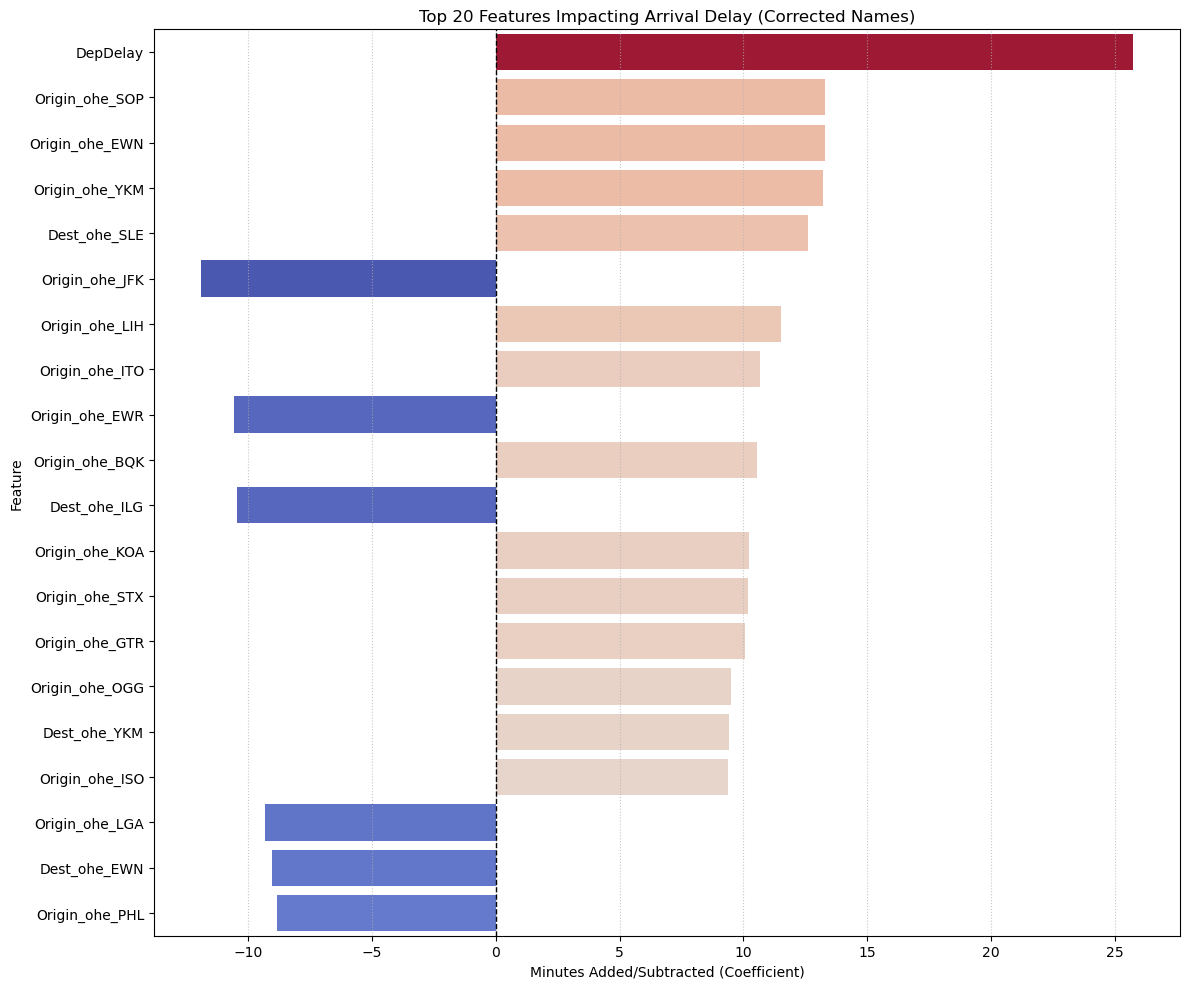

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Recuperamos el modelo lineal
lr_model = best_model_overall.bestModel.stages[-1]

# 2. Definimos manualmente los nombres de las variables numéricas
# (TIENEN QUE ESTAR EN EL MISMO ORDEN QUE EN TU LISTA numerical_cols)
numerical_cols = ["Month", "DayOfWeek", "DepHour", "DepDelay", "TaxiOut", "Distance", "PlaneAge"]
# 3. Recuperamos los atributos categóricos (que sí suelen guardar su metadata)
# Intentamos leer la metadata de la columna features para sacar los nombres del OneHot
try:
    meta = predictions.schema["features"].metadata
    attrs = meta['ml_attr']['attrs']
    
    # Spark suele llamar a las categóricas "binary" en los atributos
    categorical_features_list = []
    if 'binary' in attrs:
        categorical_features_list = attrs['binary']
        # Ordenamos por índice
        categorical_features_list.sort(key=lambda x: x['idx'])
    
    # Extraemos solo los nombres de las categóricas
    # Nota: Los índices de las numéricas suelen ir primero, así que ajustamos
    categorical_names = [x['name'] for x in categorical_features_list]

except:
    # Fallback si falla la metadata: nombres genéricos para categóricas
    print("Metadata extraction failed for categoricals. Using generic names.")
    num_cat_features = len(lr_model.coefficients) - len(numerical_cols)
    categorical_names = [f"Cat_Feature_{i}" for i in range(num_cat_features)]

# 4. Construimos la lista final de nombres
# IMPORTANTE: El VectorAssembler final unió [Numéricas + Categóricas]
all_feature_names = numerical_cols + categorical_names

# Verificación de seguridad: Longitudes deben coincidir
if len(all_feature_names) != len(lr_model.coefficients):
    print(f"Warning: Name mismatch. Names: {len(all_feature_names)}, Coeffs: {len(lr_model.coefficients)}")
    # Si no coinciden, cortamos o rellenamos para evitar error, pero revisa tu lista numerical_cols
    min_len = min(len(all_feature_names), len(lr_model.coefficients))
    all_feature_names = all_feature_names[:min_len]
    coefs = lr_model.coefficients[:min_len]
else:
    coefs = lr_model.coefficients

# 5. Crear DataFrame
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefs
})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)

# 6. Plot
plt.figure(figsize=(12, 10))
sns.barplot(data=top_features, y='Feature', x='Coefficient', 
            hue='Coefficient', palette='coolwarm', legend=False)

plt.title('Top 20 Features Impacting Arrival Delay (Corrected Names)')
plt.xlabel('Minutes Added/Subtracted (Coefficient)')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

### Explanation of the interpretation results

Based on the visualizations, it's evident that Departure Delay (DepDelay) is the paramount feature influencing flight arrival delays.The clear dominance of this feature also explains why the simpler Linear Regression model outperformed more complex algorithms like GBT, as the underlying pattern is fundamentally linear and direct.